In [114]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from delphi.utils import constants as consts
from delphi import oracle
from delphi import train
from delphi.utils import defaults
import datetime

/home/pstefanou/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Helpers

In [2]:
STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
STORE_TABLE_NAME = 'multi_log_reg'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/LogisticRegression/5b31e98e-45d5-4775-b2ac-635e2e34fd3f


# Standard Gumbel Distribution

(array([  5.,   7.,  10.,  11.,  29.,  59.,  82., 132., 152., 211., 233.,
        283., 338., 360., 399., 456., 456., 463., 420., 460., 505., 400.,
        393., 368., 348., 326., 282., 291., 250., 226., 209., 186., 184.,
        164., 141., 112., 112., 104.,  86.,  94.,  76.,  63.,  56.,  41.,
         49.,  50.,  26.,  46.,  26.,  22.,  19.,  18.,  30.,  18.,  12.,
         12.,   8.,  13.,   7.,   6.,   5.,  11.,   6.,   6.,   2.,   3.,
          4.,   2.,   3.,   2.,   1.,   2.,   1.,   2.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.2107894e+00, -2.0883522e+00, -1.9659152e+00, -1.8434781e+00,
        -1.7210410e+00, -1.5986038e+00, -1.4761667e+00, -1.3537296e+00,
        -1.2312925e+00, -1.1088554e+00, -9.8641825e-01, -8.6398113e-01,
        -7.4154401e-01, -6.1910683e-01, -4.9666974e-01, -3.7423262e-01,
        -2.5179550e-01, -1.293

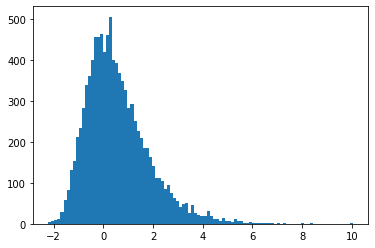

In [12]:
G = Gumbel(0, 1)

samples = G.sample(ch.Size([10000, 1])).T
plt.hist(samples, bins=100)

## Default Experiment Parameters

In [106]:
# procedure hyperparameters
train_kwargs = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'custom_lr_multiplier': consts.COSINE,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 1, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
})

args = defaults.check_and_fill_args(train_kwargs, defaults.TRAINING_ARGS, CIFAR)

# Multinomial Logistic Regression

In [101]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
M = MultivariateNormal(ch.zeros(args.IN_FEATURES), ch.eye(args.IN_FEATURES)/args.IN_FEATURES)
X = M.sample(ch.Size([args.samples]))

# determine base model logits 
z = ground_truth(X)
# add gumbel noise to all logits and take argmax
y = ch.argmax(z + G.sample(z.size()), dim=1)

ground truth weights: Parameter containing:
tensor([[-0.6029],
        [ 0.8378]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([-0.8751,  0.3895], requires_grad=True)


In [102]:
(ch.argmax(ch.log_softmax(ground_truth(X), dim=1), dim=1) == y).nonzero(as_tuple=False).flatten().size(0)/args.samples

0.7781

In [110]:
ds = TensorDataset(X, y)
loaders = (DataLoader(ds), None)

In [113]:
results = train.train_model(args, model=nn.Linear(in_features=args.IN_FEATURES, out_features=args.k, bias=args.bias), loaders=loaders)

TypeError: '<' not supported between instances of 'NoneType' and 'float'

# Gradient

In [5]:
# perform each experiment a total of 10 times
for iter_ in range(100): 
    for C in [-2, -.5, -1, -.5]:
        PREDICATE = Left(Tensor([C]))
        args.__setattr__('phi', PREDICATE)
        # generate random uniform weights
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))

        # generate data
        X = Uniform(-100, 100).sample(ch.Size([NUM_SAMPLES, DIMS]))
        z = X.mm(W) + W0 + logistic.sample(ch.Size([NUM_SAMPLES, 1]))
        y = ch.where(z > 0, 1.0, 0.0)
        # truncate
        indices = PREDICATE(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]

        args.__setattr__('alpha', Tensor([y_trunc.size(0) / NUM_SAMPLES]))

        # truncated logistic regression
        data = TruncatedLogisticRegressionDataset(x_trunc, y_trunc, bias=args.bias)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_log_reg = truncated_logistic_regression(phi=args.phi, alpha=args.alpha, bias=args.bias, epochs=args.epochs, 
                                                      lr=args.lr, num_samples=args.num_samples, tol=args.tol)
        results = trunc_log_reg.fit(S)
        w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()

        # parameter estimates 
        real_params = ch.cat([W.T, W0], axis=1)
        mle_params = ch.cat([data.w, data.w0.unsqueeze(0)], axis=1)
        delphi_params = ch.cat([w, w0.unsqueeze(0)], axis=1)

        # metrics
        mle_cos = cosine_similarity(mle_params, real_params)
        delphi_cos = cosine_similarity(delphi_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_cos': delphi_cos,
            'mle_cos': mle_cos,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

# Results

In [7]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 8/8 [00:00<00:00, 234.15it/s]

,delphi_cos,mle_cos,alpha,C,exp_id
0,0.755610,0.811039,0.5251,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
1,0.503841,-0.020497,0.5069,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
2,0.987580,0.858828,0.5075,-1.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
3,0.904469,-0.610786,0.5042,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
4,0.932691,0.932682,0.5145,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078


# All Trials

all trials:


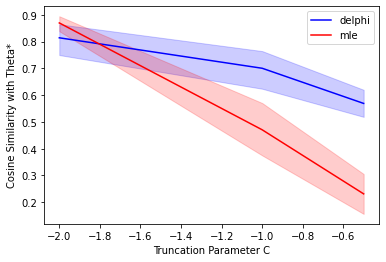

In [8]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

# Remove Best and Worst Trial from Results

In [55]:
print("remove best and worst trials:")

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_param_mse')), x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results.drop(noise_lambda('known_param_mse')), x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_param_mse')), x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_var_mse')), x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_var_mse')), x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

remove best and worst trials:


NameError: name 'noise_lambda' is not defined

In [95]:
s = Store('/home/pstefanou/LogisticRegression/', 'ae6627d0-9b20-49ca-9aca-73d0a07637c0')

In [97]:
s.close()